# PR checks

In [1]:
import pennylane as qml

## PR 1

https://github.com/PennyLaneAI/pennylane/pull/5348

In [2]:
dev = qml.device('default.qubit', wires=[0, 1, 2])

In [4]:
@qml.compile                ### DEVE ESSERE AGGIUNTO IL DECORATORE @qml.compile
@qml.qnode(device=dev)
def circuit(x, y, z):
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=2)
    qml.RZ(z, wires=2)
    qml.CNOT(wires=[2, 1])
    qml.RX(z, wires=0)
    qml.CNOT(wires=[1, 0])
    qml.RX(x, wires=0)
    qml.CNOT(wires=[1, 0])
    qml.RZ(-z, wires=2)
    qml.RX(y, wires=2)
    qml.Y(2)
    qml.CY(wires=[1, 2])
    return qml.expval(qml.Z(0))

In [5]:
def qfunc(x, y, z):
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=2)
    qml.RZ(z, wires=2)
    qml.CNOT(wires=[2, 1])
    qml.RX(z, wires=0)
    qml.CNOT(wires=[1, 0])
    qml.RX(x, wires=0)
    qml.CNOT(wires=[1, 0])
    qml.RZ(-z, wires=2)
    qml.RX(y, wires=2)
    qml.Y(2)
    qml.CY(wires=[1, 2])
    return qml.expval(qml.Z(0))

In [6]:
qnode = qml.QNode(qfunc, dev)
print(qml.draw(qnode)(0.2, 0.3, 0.4))

0: ──H──RX(0.40)────╭X──────────RX(0.20)─╭X────┤  <Z>
1: ──H───────────╭X─╰●───────────────────╰●─╭●─┤     
2: ──H──RZ(0.40)─╰●──RZ(-0.40)──RX(0.30)──Y─╰Y─┤     


In [7]:
compiled_qnode = qml.compile(qnode)
print(qml.draw(compiled_qnode)(0.2, 0.3, 0.4))

0: ──H──RX(0.60)─────────────────┤  <Z>
1: ──H─╭X──────────────────╭●────┤     
2: ──H─╰●─────────RX(0.30)─╰Y──Y─┤     


In [8]:
from functools import partial ### DEVE ESSERE AGGIUNTO

compiled_qnode = qml.compile(
    qnode,
    pipeline=[
        partial(qml.transforms.commute_controlled, direction="left"),
        partial(qml.transforms.merge_rotations, atol=1e-6),
        qml.transforms.cancel_inverses
    ],
    basis_set=["CNOT", "RX", "RY", "RZ"],
    num_passes=2
)

print(qml.draw(compiled_qnode)(0.2, 0.3, 0.4))

0: ──RZ(1.57)──RX(1.57)──RZ(1.57)──RX(0.60)─────────────────────────────────────────────────────
1: ──RZ(1.57)──RX(1.57)──RZ(1.57)─╭X─────────RZ(1.57)─────────────────────────────────────────╭●
2: ──RZ(1.57)──RX(1.57)──RZ(1.57)─╰●─────────RX(0.30)──RZ(1.57)──RY(3.14)──RZ(1.57)──RY(1.57)─╰X

────────────────┤  <Z>
─────────────╭●─┤     
───RY(-1.57)─╰X─┤     


Due cambiamenti da apportare. Da notare che quel coglione ha linkato la doc stable, ma bisogna guardare la 'latest'

## PR 2

https://github.com/PennyLaneAI/pennylane/pull/5339

Questa is una rimozione from deprecation and removal, quindi penso sia tutto a posto

## PR 3

https://github.com/PennyLaneAI/pennylane/pull/5347

In [8]:
op = qml.evolve(qml.X(0), coeff=2)
op

Evolution(-2j PauliX)

In [9]:
coeffs = [lambda p, t: p * t for _ in range(4)]
ops = [qml.X(i) for i in range(4)]

# ParametrizedHamiltonian
H = qml.dot(coeffs, ops)

# ParametrizedEvolution
ev = qml.evolve(H)

In [10]:
ev

ParametrizedEvolution(wires=[0, 1, 2, 3])

In [11]:
qml.matrix(ev([1., 2., 3., 4.], t=[0, 4]))

Array([[ 0.04929843+0.j        ,  0.        -0.03258221j,
         0.        +0.10526j   ,  0.06956796+0.j        ,
         0.        -0.01481935j, -0.00979378+0.j        ,
         0.03164092+0.j        ,  0.        -0.02091208j,
         0.        +0.33525273j,  0.22157252+0.j        ,
        -0.7158268 +0.j        ,  0.        +0.4730951j ,
         0.10077609+0.j        ,  0.        -0.06660434j,
         0.        +0.21517362j,  0.14221084+0.j        ],
       [ 0.        -0.03258221j,  0.04929843+0.j        ,
         0.06956796+0.j        ,  0.        +0.10526j   ,
        -0.00979378+0.j        ,  0.        -0.01481935j,
         0.        -0.02091208j,  0.03164092+0.j        ,
         0.22157252+0.j        ,  0.        +0.33525273j,
         0.        +0.4730951j , -0.7158268 +0.j        ,
         0.        -0.06660434j,  0.10077609+0.j        ,
         0.14221084+0.j        ,  0.        +0.21517362j],
       [ 0.        +0.10526j   ,  0.06956796+0.j        ,
         0.0

In [12]:
import jax

dev = qml.device("default.qubit.jax", wires=4)
@jax.jit
@qml.qnode(dev, interface="jax")
def circuit(params):
    qml.evolve(H)(params, t=[0, 10])
    return qml.expval(qml.Z(0))

In [13]:
params = [1., 2., 3., 4.]
circuit(params)

Array(0.8609962, dtype=float32)

In [14]:
jax.grad(circuit)(params)

[Array(50.85762, dtype=float32),
 Array(-5.347459e-05, dtype=float32),
 Array(-9.281231e-05, dtype=float32),
 Array(-0.00013054, dtype=float32)]

## PR 4

https://github.com/PennyLaneAI/pennylane/pull/5430/files

## PR 5

https://github.com/PennyLaneAI/pennylane/pull/5422

In [15]:
import jax

jax.config.update("jax_enable_x64", True)

dev = qml.device("default.qubit", wires=2, shots=100)

@qml.qnode(dev, interface="jax")
def circuit(x):
    qml.RX(x, wires=0)
    return qml.sample(qml.PauliX(0) @ qml.PauliY(1))

results = jax.jit(circuit)(jax.numpy.array(0.123, dtype=jax.numpy.float64))

import jax

jax.config.update("jax_enable_x64", True)

dev = qml.device("default.qubit", wires=2, shots=100)

@qml.qnode(dev, interface="jax")
def circuit(x):
    qml.RX(x, wires=0)
    return qml.sample(qml.PauliX(0) @ qml.PauliY(1))

results = jax.jit(circuit)(jax.numpy.array(0.123, dtype=jax.numpy.float64))

## PR 6

https://github.com/PennyLaneAI/pennylane/pull/5459

## PR 7

https://github.com/PennyLaneAI/pennylane/pull/5441

In [16]:
dev = qml.device("default.qubit")

@qml.qnode(dev)
def circuit(x, y):
    qml.RX(x, wires=0)
    qml.RY(y, wires=1)
    m0 = qml.measure(1)
    return (
        qml.sample(m0), qml.expval(m0), qml.var(m0), qml.probs(op=m0), qml.counts(op=m0),
    )

In [17]:
circuit(1.0, 2.0, shots=1000)

(array([1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
        1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 

## PR 8

https://github.com/PennyLaneAI/pennylane/pull/5455

Modifica da fare al changelog

## PR 9

https://github.com/PennyLaneAI/pennylane/pull/

In [18]:
import pennylane as qml
from pennylane import numpy as np

dev = qml.device("default.qubit")
@qml.qnode(dev)
def cost(params):
    qml.RX(params[0], wires=0)
    qml.CRY(params[1], wires=[0, 1])
    return qml.expval(qml.Z(0) @ qml.Z(1))

params = np.random.rand(2)
opt = qml.QNSPSAOptimizer(stepsize=5e-2)

for _ in range(3):
    print(type(params))
    params, loss = opt.step_and_cost(cost, params)
    #params = np.array(params) # this fixes the error

<class 'pennylane.numpy.tensor.tensor'>
<class 'pennylane.numpy.tensor.tensor'>
<class 'pennylane.numpy.tensor.tensor'>


## PR 10

https://github.com/PennyLaneAI/pennylane/pull/5450

## PR 11

https://github.com/PennyLaneAI/pennylane/pull/5352

## PR 12

https://github.com/PennyLaneAI/pennylane/pull/5395

In [19]:
@qml.qnode(qml.device('default.qubit'))
def circuit():
    qml.Hadamard(0)
    return qml.sample(wires=(0,1))

samples = circuit(shots=10)
qml.sample(wires=0).process_samples(samples, wire_order=qml.wires.Wires((0,1)))

tensor([[1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0]], requires_grad=True)

In [20]:
counts = {'00': 2, '10': 3}
qml.sample(wires=(0,1)).process_counts(counts, wire_order=qml.wires.Wires((0,1)))
qml.sample(wires=0).process_counts(counts, wire_order=qml.wires.Wires((0,1)))

array([0, 0, 1, 1, 1])

## PR 13

https://github.com/PennyLaneAI/pennylane/pull/5449

## PR 14

https://github.com/PennyLaneAI/pennylane/pull/5463

In [21]:
from pennylane.devices.qubit.sampling import get_num_shots_and_executions, _group_measurements

prod = qml.prod(qml.PauliX(0), qml.PauliY(1))
tensor = qml.operation.Tensor(qml.PauliX(0), qml.PauliY(1))

tape1 = qml.tape.QuantumScript([], measurements=[qml.expval(qml.PauliX(0)), qml.expval(prod)], shots=10)
get_num_shots_and_executions(tape1)

(1, 10)

In [22]:
all_mp_groups, all_indices = _group_measurements(tape1.measurements)
all_mp_groups

[[expval(X(0)), expval(X(0) @ Y(1))]]

In [23]:
tape2 = qml.tape.QuantumScript([], measurements=[qml.expval(qml.PauliX(0)), qml.expval(tensor)], shots=10)
get_num_shots_and_executions(tape2)

(1, 10)

In [24]:
all_mp_groups, all_indices = _group_measurements(tape2.measurements)
all_mp_groups

[[expval(X(0)), expval(X(0) @ Y(1))]]

## PR 15

https://github.com/PennyLaneAI/pennylane/pull/5525

Bisogna cambiare il changelog (the issue was linked rather than the PR)

## PR 16

https://github.com/PennyLaneAI/pennylane/pull/5515

## PR 17

https://github.com/PennyLaneAI/pennylane/pull/5562

In [25]:
qml.equal(qml.PauliX(0)@qml.GlobalPhase(np.pi), qml.PauliX(0)@qml.GlobalPhase(np.pi))

True

## PR 18

https://github.com/PennyLaneAI/pennylane/pull/5524

## PR 19

https://github.com/PennyLaneAI/pennylane/pull/5479

`doc/introduction/data.rst`

In [1]:
import pennylane as qml

import numpy as np

coeffs = [1, 0.5]
observables = [qml.Z(0), qml.X(1)]
H = qml.Hamiltonian(coeffs, observables)
energies, _ = np.linalg.eigh(qml.matrix(H)) #Calculate the energies
dataset = qml.data.Dataset(data_name = "Example", hamiltonian=H, energies=energies)
dataset.data_name
dataset.hamiltonian
#dataset.energies

1.0 * Z(0) + 0.5 * X(1)

In [41]:
# Questo non posso eseguirlo, ma chi se ne frega

dataset.write("./path/to/dataset.h5")
read_dataset = qml.data.Dataset()
read_dataset.read("./path/to/dataset.h5")
read_dataset.data_name
read_dataset.hamiltonian
read_dataset.energies

`doc/introduction/operations.rst`

In [43]:
mat = np.array([[1, 1], [1, -1]])
h = qml.pauli_decompose(mat)
type(h)

#print(h)

pennylane.ops.op_math.linear_combination.LinearCombination

`pennylane/data/__init__.py`

Mi fido

... mi fido per quasi tutte (chissene). 

`pennylane/qaoa/cycle.py`

In [2]:
import networkx as nx
g = nx.complete_graph(3).to_directed()
edge_weight_data = {edge: (i + 1) * 0.5 for i, edge in enumerate(g.edges)}
for k, v in edge_weight_data.items():
    g[k[0]][k[1]]["weight"] = v
h = qml.qaoa.cycle.loss_hamiltonian(g)
h

(
    -0.6931471805599453 * Z(0)
  + 0.0 * Z(1)
  + 0.4054651081081644 * Z(2)
  + 0.6931471805599453 * Z(3)
  + 0.916290731874155 * Z(4)
  + 1.0986122886681096 * Z(5)
)

In [3]:
import rustworkx as rx
import pennylane as qml
g = rx.generators.directed_mesh_graph(3)
edge_weight_data = {edge: (i + 1) * 0.5 for i, edge in enumerate(sorted(g.edge_list()))}
for k, v in edge_weight_data.items():
    g.update_edge(k[0], k[1], {"weight": v})
h = qml.qaoa.cycle.loss_hamiltonian(g)
print(h)

ValueError: 0 is not in list

Porco mondo che palle... chiedere a Korb per questo

In [11]:
import openfermion

q_op = 0.1 * openfermion.QubitOperator('X0') + 0.2 * openfermion.QubitOperator('Y0 Z2')
q_op

0.1 [X0] +
0.2 [Y0 Z2]

In [15]:
import numpy as np

@qml.transforms.undo_swaps
@qml.transforms.merge_rotations
@qml.transforms.cancel_inverses
@qml.qnode(qml.device('default.qubit'), diff_method="parameter-shift", shifts=np.pi / 4)
def circuit(x):
    qml.RandomLayers(qml.numpy.array([[1.0, 2.0]]), wires=(0,1))
    qml.RX(x, wires=0)
    qml.RX(-x, wires=0)
    qml.SWAP((0,1))
    qml.X(0)
    qml.X(0)
    return qml.expval(qml.X(0) + qml.Y(0))



batch, fn = qml.workflow.construct_batch(circuit, level="device")(1.23)
batch[0].circuit

[RY(tensor(1., requires_grad=True), wires=[1]),
 RX(tensor(2., requires_grad=True), wires=[0]),
 expval(X(0) + Y(0))]

## PR 20

https://github.com/PennyLaneAI/pennylane/pull/5485

Questa anche is una merda gigante, ma la facciamo ora...

In [5]:
import pennylane as qml
from pennylane import numpy as np

qml.simplify(qml.RX(4*np.pi+0.1, 0 ))
qml.simplify(qml.adjoint(qml.RX(1.23, 0)))
qml.simplify(qml.ops.Pow(qml.RX(1, 0), 3))
qml.simplify(qml.sum(qml.Y(3), qml.Y(3)))                # DEVE ESSERE CAMBIATA IN 2.0 ANZICHÈ 2    https://docs.pennylane.ai/en/latest/introduction/compiling_circuits.html
#qml.simplify(qml.RX(1, 0) @ qml.RX(1, 0))
#qml.simplify(qml.prod(qml.X(0), qml.Z(0)))

2.0 * Y(3)

In [7]:
dev = qml.device('default.qubit', wires=4)

@qml.qnode(dev, diff_method='parameter-shift')
def circuit(x, y):
    qml.RX(x[0], wires=0)
    qml.Toffoli(wires=(0, 1, 2))
    qml.CRY(x[1], wires=(0, 1))
    qml.Rot(x[2], x[3], y, wires=0)
    return qml.expval(qml.Z(0)), qml.expval(qml.X(1))

In [8]:
x = np.array([0.05, 0.1, 0.2, 0.3], requires_grad=True)
y = np.array(0.4, requires_grad=False)
specs_func = qml.specs(circuit)
specs_func(x, y)                                                # DEVE ESSERE CAMBIATO

{'resources': Resources(num_wires=3, num_gates=4, gate_types=defaultdict(<class 'int'>, {'RX': 1, 'Toffoli': 1, 'CRY': 1, 'Rot': 1}), gate_sizes=defaultdict(<class 'int'>, {1: 2, 3: 1, 2: 1}), depth=4, shots=Shots(total_shots=None, shot_vector=())),
 'errors': {},
 'num_observables': 2,
 'num_diagonalizing_gates': 1,
 'num_trainable_params': 4,
 'num_device_wires': 3,
 'device_name': 'default.qubit',
 'expansion_strategy': 'gradient',
 'gradient_options': {},
 'interface': 'auto',
 'diff_method': 'parameter-shift',
 'gradient_fn': 'pennylane.gradients.parameter_shift.param_shift',
 'num_gradient_executions': 10}

In [10]:
dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev, interface=None)
def circuit():
    qml.Snapshot(measurement=qml.expval(qml.Z(0)))
    qml.Hadamard(wires=0)
    qml.Snapshot("very_important_state")
    qml.CNOT(wires=[0, 1])
    qml.Snapshot()
    return qml.expval(qml.X(0))

circuit()

0.0

/tmp/ipykernel_279379/1845537931.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


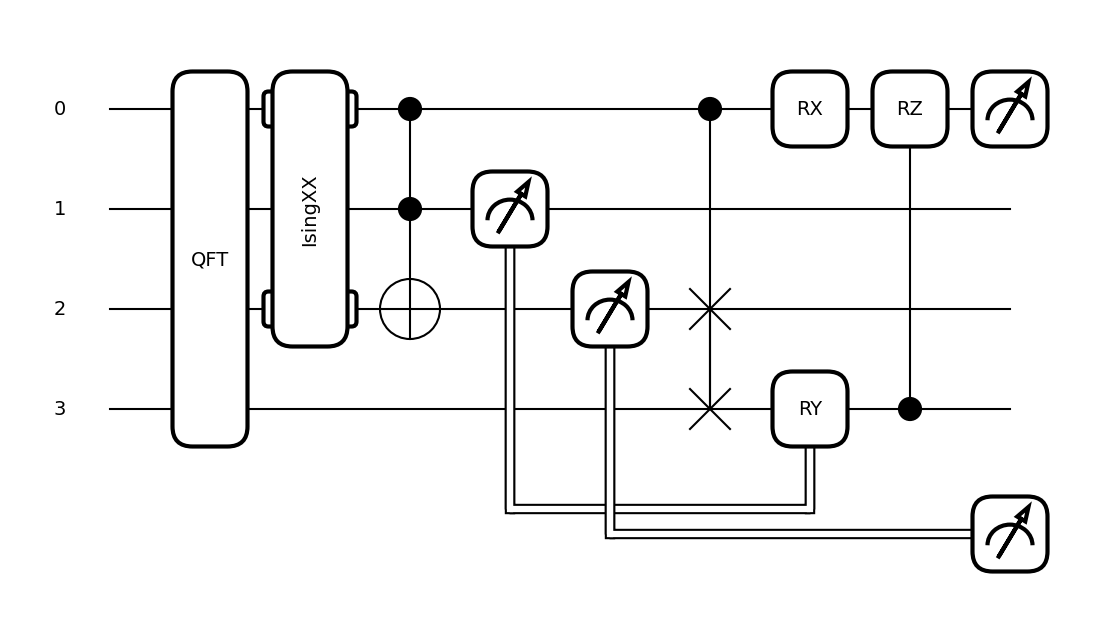

In [5]:
dev = qml.device('default.qubit')

@qml.qnode(dev)
def circuit(x, z):
    qml.QFT(wires=(0,1,2,3))
    qml.IsingXX(1.234, wires=(0,2))
    qml.Toffoli(wires=(0,1,2))
    mcm = qml.measure(1)
    mcm_out = qml.measure(2)
    qml.CSWAP(wires=(0,2,3))
    qml.RX(x, wires=0)
    qml.cond(mcm, qml.RY)(np.pi / 4, wires=3)
    qml.CRZ(z, wires=(3,0))
    return qml.expval(qml.Z(0)), qml.probs(op=mcm_out)


fig, ax = qml.draw_mpl(circuit)(1.2345,1.2345)
fig.show()

In [37]:
print(qml.draw(circuit)(1.2345,1.2345))

0: ─╭QFT─╭IsingXX(1.23)─╭●───────────╭●─────RX(1.23)─╭RZ(1.23)─┤  <Z>       
1: ─├QFT─│──────────────├●──┤↗├──────│───────────────│─────────┤            
2: ─├QFT─╰IsingXX(1.23)─╰X───║───┤↗├─├SWAP───────────│─────────┤            
3: ─╰QFT─────────────────────║────║──╰SWAP──RY(0.79)─╰●────────┤            
                             ╚════║═════════╝                               
                                  ╚════════════════════════════╡  Probs[MCM]


In [38]:
dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev, interface=None)
def circuit():
    qml.Snapshot(measurement=qml.expval(qml.Z(0)))
    qml.Hadamard(wires=0)
    qml.Snapshot("very_important_state")
    qml.CNOT(wires=[0, 1])
    qml.Snapshot()
    return qml.expval(qml.X(0))

In [39]:
circuit()

0.0

In [40]:
qml.snapshots(circuit)()

{0: 1.0,
 'very_important_state': array([0.70710678+0.j, 0.        +0.j, 0.70710678+0.j, 0.        +0.j]),
 2: array([0.70710678+0.j, 0.        +0.j, 0.        +0.j, 0.70710678+0.j]),
 'execution_results': 0.0}

In [21]:
import numpy as np

@qml.qnode(dev)
def measured_circuit(x):
    qml.IsingXX(x, wires=[0,1])
    m = qml.measure(1)
    return qml.density_matrix(wires=[0]), qml.probs(op=m)

@qml.qnode(dev)
def measured_circuit(x):
    qml.IsingXX(x, wires=[0,1])
    m = qml.measure(1)
    return qml.density_matrix(wires=[0]), qml.probs(op=m)

dm, probs = measured_circuit(np.pi/2)
#dm
#probs   # DEVE ESSERE CAMBIATO

Frisus log: supports_derivatives called with:
execution_config=ExecutionConfig(grad_on_execution=None, use_device_gradient=None, use_device_jacobian_product=False, gradient_method='best', gradient_keyword_arguments={}, device_options={}, interface=None, derivative_order=1)
circuit=None

Frisus log: supports_derivatives called with:
execution_config=ExecutionConfig(grad_on_execution=None, use_device_gradient=None, use_device_jacobian_product=False, gradient_method='best', gradient_keyword_arguments={}, device_options={}, interface=None, derivative_order=1)
circuit=None

Frisus log: supports_derivatives called with:
execution_config=ExecutionConfig(grad_on_execution=None, use_device_gradient=None, use_device_jacobian_product=False, gradient_method='best', gradient_keyword_arguments={}, device_options={}, interface=None, derivative_order=1)
circuit=<QuantumScript: wires=[0, 1], params=0>

Frisus log: supports_derivatives called with:
execution_config=ExecutionConfig(grad_on_execution=None

In [11]:
import pennylane as qml
from pennylane import CircuitGraph

dev = qml.device('lightning.qubit', wires=(0,1,2,3))

@qml.qnode(dev)
def circuit():
    qml.Hadamard(0)
    qml.CNOT([1, 2])
    qml.CNOT([2, 3])
    qml.CNOT([3, 1])
    return qml.expval(qml.Z(0))


circuit()
tape = circuit.qtape
ops = tape.operations
obs = tape.observables
g = CircuitGraph(ops, obs, tape.wires)

Frisus log: supports_derivatives called with:
execution_config=ExecutionConfig(grad_on_execution=None, use_device_gradient=None, use_device_jacobian_product=False, gradient_method='best', gradient_keyword_arguments={}, device_options={}, interface=None, derivative_order=1)
circuit=None

Frisus log: supports_derivatives called with:
execution_config=ExecutionConfig(grad_on_execution=None, use_device_gradient=None, use_device_jacobian_product=False, gradient_method='best', gradient_keyword_arguments={}, device_options={}, interface=None, derivative_order=1)
circuit=<QuantumScript: wires=[0, 1, 2, 3], params=0>

Frisus log: execute_and_compute_derivatives called with:
execution_config=ExecutionConfig(grad_on_execution=True, use_device_gradient=True, use_device_jacobian_product=False, gradient_method='adjoint', gradient_keyword_arguments={}, device_options={'rng': Generator(PCG64) at 0x7A1B8113D4A0, 'c_dtype': <class 'numpy.complex128'>, 'batch_obs': False, 'mcmc': False, 'kernel_name': No

In [12]:
type(g.graph)     # DEVE ESSERE CAMBIATO

rustworkx.PyDiGraph

In [13]:
g.has_path(ops[0], ops[1])
#g.has_path(ops[1], ops[3])

False

In [47]:
g.has_path(ops[0], obs[0])
#g.has_path(ops[1], obs[0])
#g.has_path(obs[0], ops[0])

True

In [48]:
g2 = qml.qcut.tape_to_graph(tape)
type(g2)
for k, v in g2.adjacency():
   print(k, v)                             # QUESTO VA CAMBIATO

Wrapped(Hadamard(wires=[0])) {Wrapped(expval(Z(0))): {0: {'wire': 0}}}
Wrapped(CNOT(wires=[1, 2])) {Wrapped(CNOT(wires=[2, 3])): {0: {'wire': 2}}, Wrapped(CNOT(wires=[3, 1])): {0: {'wire': 1}}}
Wrapped(CNOT(wires=[2, 3])) {Wrapped(CNOT(wires=[3, 1])): {0: {'wire': 3}}}
Wrapped(CNOT(wires=[3, 1])) {}
Wrapped(expval(Z(0))) {}


In [49]:
def circuit(x, y, z):
    qml.RX(x, wires=0)
    qml.RX(y, wires=0)
    qml.CNOT(wires=[1, 2])
    qml.RY(y, wires=1)
    qml.Hadamard(wires=2)
    qml.CRZ(z, wires=[2, 0])
    qml.RY(-y, wires=1)
    return qml.expval(qml.Z(0))
dag_fn = qml.commutation_dag(circuit)
dag = dag_fn(np.pi / 4, np.pi / 3, np.pi / 2)

In [50]:
nodes = dag.get_nodes()
nodes

NodeDataView({0: <pennylane.transforms.commutation_dag.CommutationDAGNode object at 0x7d62284d9ac0>, 1: <pennylane.transforms.commutation_dag.CommutationDAGNode object at 0x7d62284d9e20>, 2: <pennylane.transforms.commutation_dag.CommutationDAGNode object at 0x7d62284d9c40>, 3: <pennylane.transforms.commutation_dag.CommutationDAGNode object at 0x7d62284d9ca0>, 4: <pennylane.transforms.commutation_dag.CommutationDAGNode object at 0x7d62284d9d60>, 5: <pennylane.transforms.commutation_dag.CommutationDAGNode object at 0x7d62284d9a60>, 6: <pennylane.transforms.commutation_dag.CommutationDAGNode object at 0x7d62284d9dc0>}, data='node')

In [57]:
dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev)
def measured_circuit(x):
    qml.IsingXX(x, wires=[0,1])
    m = qml.measure(1)
    return qml.density_matrix(wires=[0]), qml.probs(op=m)

dm, probs = measured_circuit(np.pi/2)

In [58]:
dm

tensor([[0.5+0.j, 0. +0.j],
        [0. +0.j, 0.5+0.j]], requires_grad=True)

In [59]:
probs

tensor([0.5, 0.5], requires_grad=True)

In [22]:
import pennylane.numpy as pnp

dev = qml.device("default.qubit")

@qml.qnode(dev)
def circ(params):
    qml.RX(params[0], wires=0)
    qml.CNOT([0, 1])
    qml.CRY(params[1], wires=[1, 0])
    qml.Hadamard(1)
    return qml.probs(wires=[0, 1])

In [24]:
pnp.random.seed(25)
params = pnp.random.random(2)
circ(params)                                # MUST BE CHANGED

tensor([0.41850088, 0.41850088, 0.08149912, 0.08149912], requires_grad=True)

In [25]:
cfim_func = qml.qinfo.classical_fisher(circ)
cfim_func(params)                           # MUST BE CHANGED

tensor([[ 0.90156094, -0.12555804],
        [-0.12555804,  0.01748614]], requires_grad=True)

In [26]:
H = qml.Hamiltonian([1., 1.], [qml.Z(0) @ qml.Z(1), qml.X(0) @ qml.Z(1)])

dev = qml.device("default.qubit", shots=10000)

# shadow_expval + mid-circuit measurements require to defer measurements
@qml.defer_measurements
@qml.qnode(dev)
def qnode(x):
    qml.Hadamard(0)
    qml.CNOT((0,1))
    qml.RX(x, wires=0)
    qml.measure(1)
    return qml.shadow_expval(H)

x = np.array(0.5, requires_grad=True)

TypeError: array() got an unexpected keyword argument 'requires_grad'

In [69]:
qnode(x)
#qml.grad(qnode)(x)

array(0.8514)

In [70]:
wires = 3

dev = qml.device('default.qubit',wires=wires)

@qml.qnode(dev)
def circuit_qft(basis_state):
    qml.BasisState(basis_state, wires=range(wires))
    qml.QFT(wires=range(wires))
    return qml.state()

In [71]:
circuit_qft(np.array([1.0, 0.0, 0.0]))

tensor([ 0.35355339+0.j, -0.35355339+0.j,  0.35355339+0.j,
        -0.35355339+0.j,  0.35355339+0.j, -0.35355339+0.j,
         0.35355339+0.j, -0.35355339+0.j], requires_grad=True)

In [31]:
dev = qml.device("default.qubit", shots=1)

@qml.qnode(dev)
def qft_add(m, k, n_wires):
    qml.BasisEmbedding(m, wires=range(n_wires))
    qml.adjoint(qml.QFT)(wires=range(n_wires))
    for j in range(n_wires):
        qml.RZ(-k * np.pi / (2**j), wires=j)
    qml.QFT(wires=range(n_wires))
    return qml.sample()

In [32]:
qft_add(7, 3, n_wires=4)

array([1, 0, 1, 0])

In [33]:
def scFT(n_wires):
    '''semiclassical Fourier transform'''
    for w in range(n_wires-1):
        qml.Hadamard(w)
        mcm = qml.measure(w)
        for m in range(w + 1, n_wires):
            qml.cond(mcm, qml.PhaseShift)(np.pi / 2 ** (m + 1), wires=m)
    qml.Hadamard(n_wires-1)

@qml.qnode(dev)
def scFT_add(m, k, n_wires):
    qml.BasisEmbedding(m, wires=range(n_wires))
    qml.adjoint(qml.QFT)(wires=range(n_wires))
    for j in range(n_wires):
        qml.RZ(-k * np.pi / (2**j), wires=j)
    scFT(n_wires)
    # Revert wire order because of PL's QFT convention
    return qml.sample(wires=list(range(n_wires-1, -1, -1)))

In [34]:
scFT_add(7, 3, n_wires=4)

array([1, 0, 1, 0])

## PR 21

https://github.com/PennyLaneAI/pennylane/pull/5273

## PR 22

https://github.com/PennyLaneAI/pennylane/pull/5418

In [1]:
import pennylane as qml

def example_value(m):
    tape = qml.tape.QuantumScript((), (m,), shots=50)
    return qml.device('default.qubit').execute(tape)
example_value(qml.probs(wires=0))
#example_value(qml.expval(qml.Z(0)))
#example_value(qml.counts(wires=0))
#example_value(qml.sample(wires=0))

array([1., 0.])

In [10]:
qml.probs().wires
tape = qml.tape.QuantumScript([qml.S(0)], (qml.probs(),))
qml.device('default.qubit').execute(tape)
print(qml.device('default.mixed', wires=(0,1,2)).execute(tape))           # DEVE ESSERE CAMBIATO

[1. 0. 0. 0. 0. 0. 0. 0.]


In [8]:
import numpy as np

op = qml.RX((0, np.pi/4, np.pi/2), wires=0)                               # DEVE ESSERE CAMBIATO (THERE IS UNA PARENTESI DI TROPPO)
tape = qml.tape.QuantumScript((op,), [qml.probs(wires=0)])
result = qml.device('default.qubit').execute(tape)
result
#result.shape
#tape = qml.tape.QuantumScript((op,), [qml.expval(qml.Z(0))])
#result = qml.device('default.qubit').execute(tape)
#result
#result.shape

array([[1.        , 0.        ],
       [0.85355339, 0.14644661],
       [0.5       , 0.5       ]])

In [94]:
tape = qml.tape.QuantumScript((op,), (qml.counts(),), shots=50)
result = qml.device('default.qubit').execute(tape)
result
batch, fn = qml.transforms.broadcast_expand(tape)
fn(qml.device('default.qubit').execute(batch))

array([{'0': 50}, {'0': 39, '1': 11}, {'0': 27, '1': 23}], dtype=object)

In [95]:
tape = qml.tape.QuantumScript((), (qml.expval(qml.Z(0)), qml.probs(wires=0), qml.state()))
qml.device('default.qubit').execute(tape)

(1.0, array([1., 0.]), array([1.+0.j, 0.+0.j]))

In [112]:
measurements = (qml.expval(qml.Z(0)), qml.probs(wires=0))
tape = qml.tape.QuantumScript((), measurements, shots=(50,50,50))
result = qml.device('default.qubit').execute(tape)
result
#result[0]
#tape = qml.tape.QuantumScript((), [qml.counts(wires=0)], shots=(1, 10, 100))
#qml.device('default.qubit').execute(tape)

((1.0, array([1., 0.])), (1.0, array([1., 0.])), (1.0, array([1., 0.])))

In [104]:
op = qml.RX((1.2, 2.3, 3.4), 0)
ms = (qml.expval(qml.Z(0)), qml.probs(wires=0), qml.counts())
tape = qml.tape.QuantumScript((op,), ms, shots=(1, 100, 1000))
result = qml.device('default.qubit').execute(tape)
result

((array([-1., -1., -1.]),
  array([[0., 1.],
         [0., 1.],
         [0., 1.]]),
  [{'1': 1}, {'1': 1}, {'1': 1}]),
 (array([ 0.36, -0.58, -0.98]),
  array([[0.67, 0.33],
         [0.15, 0.85],
         [0.  , 1.  ]]),
  [{'0': 67, '1': 33}, {'0': 15, '1': 85}, {'1': 100}]),
 (array([ 0.336, -0.692, -0.958]),
  array([[0.667, 0.333],
         [0.169, 0.831],
         [0.015, 0.985]]),
  [{'0': 667, '1': 333}, {'0': 169, '1': 831}, {'0': 15, '1': 985}]))

In [105]:
result[0][0] # first shot value, first measurement
result[0][0][0] # first shot value, first measurement, and parameter of 1.2
result[1][2] # second shot value, third measurement, all three parameter values

[{'0': 67, '1': 33}, {'0': 15, '1': 85}, {'1': 100}]

In [107]:
tape1 = qml.tape.QuantumScript([qml.X(0)], [qml.state()])
tape2 = qml.tape.QuantumScript([qml.Hadamard(0)], [qml.counts()], shots=100)
tape3 = qml.tape.QuantumScript([], [qml.expval(qml.Z(0)), qml.expval(qml.X(0))])
batch = (tape1, tape2, tape3)
qml.device('default.qubit').execute(batch)

(array([0.+0.j, 1.+0.j]), {'0': 44, '1': 56}, (1.0, 0.0))

## PR 23

https://github.com/PennyLaneAI/pennylane/pull/5514

In [116]:
import pennylane as qml
import torch

shots=100
#qml.enable_return()

measurements = [qml.counts(qml.PauliZ(0)), qml.counts(wires=[0])]

devices = ["default.mixed"]


for m in measurements:
    for d in devices:
        dev = qml.device(d, wires=2, shots=shots)

        def circuit(x):
            qml.Hadamard(wires=[0])
            qml.CRX(x, wires=[0, 1])
            return qml.apply(m)

        qnode = qml.QNode(circuit, dev, diff_method=None)
        res = qnode(torch.tensor(0.5, requires_grad=True))
        print(res)

{-1: 45, 1: 55}
{'0': 56, '1': 44}


In [117]:
import pennylane as qml
import numpy as np

dev = qml.device("default.qubit", shots=10)

@qml.qnode(dev)
def f(x):
    for i in range(100):
        qml.RY(x, 0)
        m = qml.measure(0)
    return qml.expval(qml.PauliX(0))

x = np.array([0.4, 0.6])
f(x)

array([-0.6,  0.2])

## PR 24

https://github.com/PennyLaneAI/pennylane/pull/5473

## PR 25

https://github.com/PennyLaneAI/pennylane/pull/5451

Non funziona un bene amato cazzo

In [1]:
import scipy

import pennylane as qml

n_wires = 5
num_qscripts = 5
qscripts = []
for i in range(num_qscripts):
    unitary = scipy.stats.unitary_group(dim=3**n_wires, seed=(42 + i)).rvs()
    op = qml.QutritUnitary(unitary, wires=range(n_wires))
    qs = qml.tape.QuantumScript([op], [qml.expval(qml.GellMann(0, 3))])
    qscripts.append(qs)

In [3]:
from pennylane.devices.default_qutrit_mixed import DefaultQutritMixed

In [4]:
dev = DefaultQutritMixed()
program, execution_config = dev.preprocess()
new_batch, post_processing_fn = program(qscripts)
results = dev.execute(new_batch, execution_config=execution_config)
post_processing_fn(results)

(0.08015701503959316,
 0.045214142115993505,
 -0.021523213008968645,
 0.06212028503242595,
 -0.0635052317625)

In [5]:
from pennylane.devices import ExecutionConfig
dev.supports_derivatives(ExecutionConfig(gradient_method="backprop"))

True

In [10]:
import jax

@jax.jit
def f(x):
    qs = qml.tape.QuantumScript([qml.TRX(x, 0)], [qml.expval(qml.GellMann(0, 3))])
    program, execution_config = dev.preprocess()
    new_batch, post_processing_fn = program([qs])
    results = dev.execute(new_batch, execution_config=execution_config)
    return post_processing_fn(results)

In [11]:
jax.config.update("jax_enable_x64", True)
print(f(jax.numpy.array(1.2)))
print(jax.grad(f)(jax.numpy.array(1.2)))

(Array(0.36235775, dtype=float64),)


TypeError: Gradient only defined for scalar-output functions. Output was (Array(0.36235775, dtype=float64),).

In [9]:
import jax
import pennylane as qml
import scipy

n_wires = 2
num_qscripts = 2
qscripts = []
for i in range(num_qscripts):
    unitary = scipy.stats.unitary_group(dim=3**n_wires, seed=(42 + i)).rvs()
    op = qml.QutritUnitary(unitary, wires=range(n_wires))
    qs = qml.tape.QuantumScript([op], [qml.expval(qml.GellMann(0, 3))])
    qscripts.append(qs)

dev = qml.devices.DefaultQutritMixed()
program, execution_config = dev.preprocess()
new_batch, post_processing_fn = program(qscripts)
results = dev.execute(new_batch, execution_config=execution_config)
print(post_processing_fn(results))

@jax.jit
def f(x):
    qs = qml.tape.QuantumScript([qml.TRX(x, 0)], [qml.expval(qml.GellMann(0, 3))])
    program, execution_config = dev.preprocess()
    new_batch, post_processing_fn = program([qs])
    results = dev.execute(new_batch, execution_config=execution_config)
    return post_processing_fn(results)[0]

jax.config.update("jax_enable_x64", True)
print(f(jax.numpy.array(1.2)))
print(jax.grad(f)(jax.numpy.array(1.2)))

(-0.16080672463537063, -0.3598577856750845)
0.36235775447667357
-0.9320390859672264


## PR 26

https://github.com/PennyLaneAI/pennylane/pull/5161

In [12]:
from pennylane import X,Y,Z
from pennylane.pauli.dla.lie_closure import PauliVSpace

ops = [
    X(0) @ X(1) + Y(0) @ Y(1),
    X(0) @ X(1),
    Y(0) @ Y(1)
]

vspace = PauliVSpace(ops)

In [13]:
vspace.basis

[1.0 * X(0) @ X(1)
 + 1.0 * Y(0) @ Y(1),
 1.0 * X(0) @ X(1)]

In [14]:
vspace.add(qml.X(0))

[1.0 * X(0) @ X(1)
 + 1.0 * Y(0) @ Y(1),
 1.0 * X(0) @ X(1),
 1.0 * X(0)]

In [15]:
vspace.add(Y(0) @ Y(1))

[1.0 * X(0) @ X(1)
 + 1.0 * Y(0) @ Y(1),
 1.0 * X(0) @ X(1),
 1.0 * X(0)]

In [16]:
ops = [X(0), X(1)]
vspace = qml.pauli.PauliVSpace(ops)
vspace.add(Y(0))
vspace

[1.0 * X(0), 1.0 * X(1), 1.0 * Y(0)]

In [17]:
vspace.add([Z(0), X(0)])

[1.0 * X(0), 1.0 * X(1), 1.0 * Y(0), 1.0 * Z(0)]

In [19]:
ops = [X(0), X(1)]
vspace = PauliVSpace([op.pauli_rep for op in ops])
vspace.is_independent(X(0).pauli_rep)
#vspace.is_independent(Y(0).pauli_rep)

False